### Данный ноутбук обрабатывает текст сообщений: удаляет стоп слова, проводит лемматизацию и стемминг

In [69]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time
import pickle
import nltk
from nltk.corpus import stopwords
from nltk.corpus import brown
import re
from tqdm import tqdm_notebook as tqdm
from nltk.stem import SnowballStemmer

In [70]:
#удалить перепосты
# в режексе заменять на пробел
# удалить слова с леном 1
df = pd.read_csv(r'C:\Users\79627\Desktop\КР\данные\text_lower_ticker_flag_dt.csv', sep='|')
df.head()

,date,message,src,type,msg_lower,ticker,day,month,year,day_of_week,dt
0,20220115.0,"Как курс доллара на конец года стал известен, ...",01_dohod_invest_talks,chat,"как курс доллара на конец года стал известен, ...",sngs,15,1,2022,5,2022-01-15 05:33:06+00:00
1,20220113.0,"Как показывает статистика, желающих регулярно ...",01_dohod_invest_talks,chat,"как показывает статистика, желающих регулярно ...",sber,13,1,2022,3,2022-01-13 23:17:11+00:00
2,20211228.0,А чего Тинькофф белены объелся и не хочет новы...,01_dohod_invest_talks,chat,а чего тинькофф белены объелся и не хочет новы...,tcsg,28,12,2021,1,2021-12-28 06:39:47+00:00
3,20211227.0,В данном случае я с ВТБ поговорю :) Инвестинг ...,01_dohod_invest_talks,chat,в данном случае я с втб поговорю :) инвестинг ...,vtbr,27,12,2021,0,2021-12-27 20:00:32+00:00
4,20211227.0,"Ну, видимо, ВТБ не очень хорошо умеет считать ...",01_dohod_invest_talks,chat,"ну, видимо, втб не очень хорошо умеет считать ...",vtbr,27,12,2021,0,2021-12-27 19:51:25+00:00


In [71]:
df.src.unique()

array(['01_dohod_invest_talks', '02_AK47PFLCHAT', '03_cubishkachat',
       '04_cbrstockschat', '05_invest_future_chat', '06_fondrynok',
       '07_gramotnye_investicii', '08_if_stocks_chat',
       '09_fintraining_link', '10_russianmacro2020', '11_moex',
       '12_vtbmyinvestments', '13_tinkoff_invest_official',
       '14_lemonfortea', '15_investfuture', '16_SberInvestments',
       '17_bitkogan', '18_banksta', '19_markettwits', '20_FatCat18',
       '21_AK47pfl', '22_BizLike', '23_headlines_for_traders',
       '24_russianmacro', '25_alfawealth', '26_div_invest', '27_dohod',
       '28_selfinvestor', '29_trader_chernyh', '30_finamalert'],
      dtype=object)

Text(0, 0.5, 'Число сообщений')

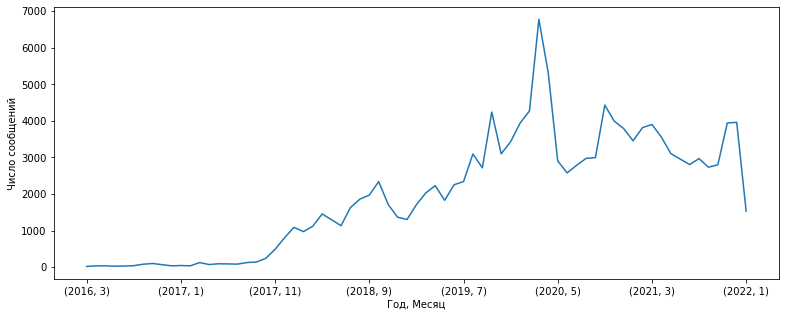

In [72]:
plt.figure(figsize=(13,5))
plot1 = df.groupby(['year', 'month']).count().message.plot()
plot1.set_xlabel('Год, Месяц')
plot1.set_ylabel('Число сообщений')

In [73]:
df.message[511]

'https://www.tinkoff.ru/about/news/23032020-tinkoff-deposit-rates-increase/ Блин, а у меня в портфеле есть Тинькофф. Неужели они всё?'

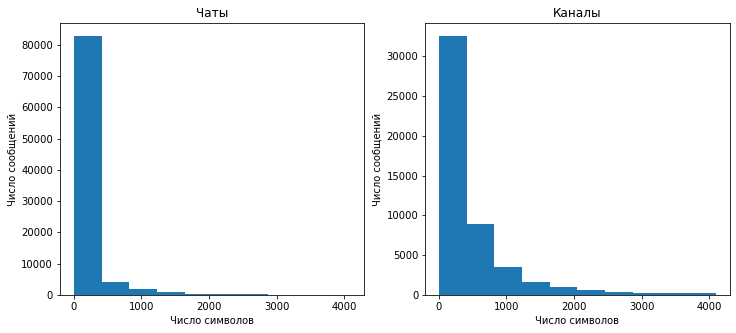

In [74]:
fig, axes = plt.subplots(1, 2)
axes[0].set_title('Чаты')
axes[1].set_title('Каналы')

z = df.query('type=="chat"').msg_lower.str.len().hist(figsize=(12, 5), ax=axes[0])
z.set_xlabel('Число символов')
z.set_ylabel('Число сообщений')

x = df.query('type=="channel"').msg_lower.str.len().hist(figsize=(12, 5), ax=axes[1])
x.set_xlabel('Число символов')
x.set_ylabel('Число сообщений')
axes[0].grid(False)
axes[1].grid(False)

Text(0, 0.5, 'Число сообщений')

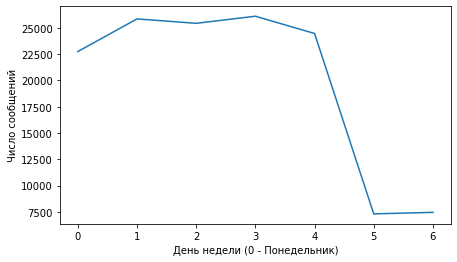

In [75]:
plt.figure(figsize=(7,4))
plot1 = df.groupby(['day_of_week']).count().message.plot()
plot1.set_xlabel('День недели (0 - Понедельник)')
plot1.set_ylabel('Число сообщений')

In [76]:
df.groupby(['src', 'year']).count().message

src                    year
01_dohod_invest_talks  2016    200
                       2017    583
                       2018    883
                       2019    281
                       2020    528
                              ... 
29_trader_chernyh      2020    323
                       2021    389
                       2022      2
30_finamalert          2021    820
                       2022     20
Name: message, Length: 137, dtype: int64

In [77]:
df.groupby(['type', 'year']).count().message

type     year
channel  2016      279
         2017     1423
         2018     7351
         2019    10486
         2020    13271
         2021    15934
         2022      425
chat     2016      200
         2017      919
         2018    10605
         2019    19797
         2020    33482
         2021    24084
         2022     1108
Name: message, dtype: int64

In [78]:
# Удаляем перенос строки
df = df.replace('\n',' ', regex=True)
df.head()

,date,message,src,type,msg_lower,ticker,day,month,year,day_of_week,dt
0,20220115.0,"Как курс доллара на конец года стал известен, ...",01_dohod_invest_talks,chat,"как курс доллара на конец года стал известен, ...",sngs,15,1,2022,5,2022-01-15 05:33:06+00:00
1,20220113.0,"Как показывает статистика, желающих регулярно ...",01_dohod_invest_talks,chat,"как показывает статистика, желающих регулярно ...",sber,13,1,2022,3,2022-01-13 23:17:11+00:00
2,20211228.0,А чего Тинькофф белены объелся и не хочет новы...,01_dohod_invest_talks,chat,а чего тинькофф белены объелся и не хочет новы...,tcsg,28,12,2021,1,2021-12-28 06:39:47+00:00
3,20211227.0,В данном случае я с ВТБ поговорю :) Инвестинг ...,01_dohod_invest_talks,chat,в данном случае я с втб поговорю :) инвестинг ...,vtbr,27,12,2021,0,2021-12-27 20:00:32+00:00
4,20211227.0,"Ну, видимо, ВТБ не очень хорошо умеет считать ...",01_dohod_invest_talks,chat,"ну, видимо, втб не очень хорошо умеет считать ...",vtbr,27,12,2021,0,2021-12-27 19:51:25+00:00


In [79]:
f = df.copy()
f.rename(columns = {'msg_lower':'text'}, inplace=True)
f.head()

,date,message,src,type,text,ticker,day,month,year,day_of_week,dt
0,20220115.0,"Как курс доллара на конец года стал известен, ...",01_dohod_invest_talks,chat,"как курс доллара на конец года стал известен, ...",sngs,15,1,2022,5,2022-01-15 05:33:06+00:00
1,20220113.0,"Как показывает статистика, желающих регулярно ...",01_dohod_invest_talks,chat,"как показывает статистика, желающих регулярно ...",sber,13,1,2022,3,2022-01-13 23:17:11+00:00
2,20211228.0,А чего Тинькофф белены объелся и не хочет новы...,01_dohod_invest_talks,chat,а чего тинькофф белены объелся и не хочет новы...,tcsg,28,12,2021,1,2021-12-28 06:39:47+00:00
3,20211227.0,В данном случае я с ВТБ поговорю :) Инвестинг ...,01_dohod_invest_talks,chat,в данном случае я с втб поговорю :) инвестинг ...,vtbr,27,12,2021,0,2021-12-27 20:00:32+00:00
4,20211227.0,"Ну, видимо, ВТБ не очень хорошо умеет считать ...",01_dohod_invest_talks,chat,"ну, видимо, втб не очень хорошо умеет считать ...",vtbr,27,12,2021,0,2021-12-27 19:51:25+00:00


In [80]:
f.text = f.text.astype(str)
f['text'] = f['text'].str.replace('ё', 'е')
f.to_csv('text_lower_tic_all_flag_all_dt_e.csv', sep='|', index=False)
f.head()

,date,message,src,type,text,ticker,day,month,year,day_of_week,dt
0,20220115.0,"Как курс доллара на конец года стал известен, ...",01_dohod_invest_talks,chat,"как курс доллара на конец года стал известен, ...",sngs,15,1,2022,5,2022-01-15 05:33:06+00:00
1,20220113.0,"Как показывает статистика, желающих регулярно ...",01_dohod_invest_talks,chat,"как показывает статистика, желающих регулярно ...",sber,13,1,2022,3,2022-01-13 23:17:11+00:00
2,20211228.0,А чего Тинькофф белены объелся и не хочет новы...,01_dohod_invest_talks,chat,а чего тинькофф белены объелся и не хочет новы...,tcsg,28,12,2021,1,2021-12-28 06:39:47+00:00
3,20211227.0,В данном случае я с ВТБ поговорю :) Инвестинг ...,01_dohod_invest_talks,chat,в данном случае я с втб поговорю :) инвестинг ...,vtbr,27,12,2021,0,2021-12-27 20:00:32+00:00
4,20211227.0,"Ну, видимо, ВТБ не очень хорошо умеет считать ...",01_dohod_invest_talks,chat,"ну, видимо, втб не очень хорошо умеет считать ...",vtbr,27,12,2021,0,2021-12-27 19:51:25+00:00


In [81]:
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('omw')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\79627\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\79627\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\79627\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw to
[nltk_data]     C:\Users\79627\AppData\Roaming\nltk_data...
[nltk_data]   Package omw is already up-to-date!


True

In [82]:
def clear_text(x):
    return re.sub(' +',u' ', re.sub(u'[^а-я ]',u'', x.lower()))
f['text'] = f['text'].astype(str)
f['text_reg'] = f['text'].apply(clear_text)
f.head()

,date,message,src,type,text,ticker,day,month,year,day_of_week,dt,text_reg
0,20220115.0,"Как курс доллара на конец года стал известен, ...",01_dohod_invest_talks,chat,"как курс доллара на конец года стал известен, ...",sngs,15,1,2022,5,2022-01-15 05:33:06+00:00,как курс доллара на конец года стал известен я...
1,20220113.0,"Как показывает статистика, желающих регулярно ...",01_dohod_invest_talks,chat,"как показывает статистика, желающих регулярно ...",sber,13,1,2022,3,2022-01-13 23:17:11+00:00,как показывает статистика желающих регулярно п...
2,20211228.0,А чего Тинькофф белены объелся и не хочет новы...,01_dohod_invest_talks,chat,а чего тинькофф белены объелся и не хочет новы...,tcsg,28,12,2021,1,2021-12-28 06:39:47+00:00,а чего тинькофф белены объелся и не хочет новы...
3,20211227.0,В данном случае я с ВТБ поговорю :) Инвестинг ...,01_dohod_invest_talks,chat,в данном случае я с втб поговорю :) инвестинг ...,vtbr,27,12,2021,0,2021-12-27 20:00:32+00:00,в данном случае я с втб поговорю инвестинг же ...
4,20211227.0,"Ну, видимо, ВТБ не очень хорошо умеет считать ...",01_dohod_invest_talks,chat,"ну, видимо, втб не очень хорошо умеет считать ...",vtbr,27,12,2021,0,2021-12-27 19:51:25+00:00,ну видимо втб не очень хорошо умеет считать пр...


In [83]:
print(f.shape)
f = f[f.text_reg != '']
f.to_csv('text_lower_tic_all_flag_all_dt_e_reg.csv', sep='|', index=False)
print(f.shape)
f.head()

(139364, 12)
(138300, 12)


,date,message,src,type,text,ticker,day,month,year,day_of_week,dt,text_reg
0,20220115.0,"Как курс доллара на конец года стал известен, ...",01_dohod_invest_talks,chat,"как курс доллара на конец года стал известен, ...",sngs,15,1,2022,5,2022-01-15 05:33:06+00:00,как курс доллара на конец года стал известен я...
1,20220113.0,"Как показывает статистика, желающих регулярно ...",01_dohod_invest_talks,chat,"как показывает статистика, желающих регулярно ...",sber,13,1,2022,3,2022-01-13 23:17:11+00:00,как показывает статистика желающих регулярно п...
2,20211228.0,А чего Тинькофф белены объелся и не хочет новы...,01_dohod_invest_talks,chat,а чего тинькофф белены объелся и не хочет новы...,tcsg,28,12,2021,1,2021-12-28 06:39:47+00:00,а чего тинькофф белены объелся и не хочет новы...
3,20211227.0,В данном случае я с ВТБ поговорю :) Инвестинг ...,01_dohod_invest_talks,chat,в данном случае я с втб поговорю :) инвестинг ...,vtbr,27,12,2021,0,2021-12-27 20:00:32+00:00,в данном случае я с втб поговорю инвестинг же ...
4,20211227.0,"Ну, видимо, ВТБ не очень хорошо умеет считать ...",01_dohod_invest_talks,chat,"ну, видимо, втб не очень хорошо умеет считать ...",vtbr,27,12,2021,0,2021-12-27 19:51:25+00:00,ну видимо втб не очень хорошо умеет считать пр...


In [84]:
from pyaspeller import YandexSpeller
speller = YandexSpeller()
speller.spelled('сбербонк')

'сбербанк'

In [85]:
f = pd.read_csv('text_lower_tic_all_flag_all_dt_e_reg.csv', sep='|')
f.head()

,date,message,src,type,text,ticker,day,month,year,day_of_week,dt,text_reg
0,20220115.0,"Как курс доллара на конец года стал известен, ...",01_dohod_invest_talks,chat,"как курс доллара на конец года стал известен, ...",sngs,15,1,2022,5,2022-01-15 05:33:06+00:00,как курс доллара на конец года стал известен я...
1,20220113.0,"Как показывает статистика, желающих регулярно ...",01_dohod_invest_talks,chat,"как показывает статистика, желающих регулярно ...",sber,13,1,2022,3,2022-01-13 23:17:11+00:00,как показывает статистика желающих регулярно п...
2,20211228.0,А чего Тинькофф белены объелся и не хочет новы...,01_dohod_invest_talks,chat,а чего тинькофф белены объелся и не хочет новы...,tcsg,28,12,2021,1,2021-12-28 06:39:47+00:00,а чего тинькофф белены объелся и не хочет новы...
3,20211227.0,В данном случае я с ВТБ поговорю :) Инвестинг ...,01_dohod_invest_talks,chat,в данном случае я с втб поговорю :) инвестинг ...,vtbr,27,12,2021,0,2021-12-27 20:00:32+00:00,в данном случае я с втб поговорю инвестинг же ...
4,20211227.0,"Ну, видимо, ВТБ не очень хорошо умеет считать ...",01_dohod_invest_talks,chat,"ну, видимо, втб не очень хорошо умеет считать ...",vtbr,27,12,2021,0,2021-12-27 19:51:25+00:00,ну видимо втб не очень хорошо умеет считать пр...


In [86]:
print(f.shape)
f.drop_duplicates(['ticker', 'text_reg'], inplace=True)
print(f.shape)
f.drop_duplicates(['text_reg'], keep=False, inplace=True)
print(f.shape)

(138300, 12)
(136051, 12)
(135701, 12)


f.shape[0]//2000
#out = df.copy()

f.text_reg = f.text_reg.astype(str)
f['text_reg_spell'] = None

low = 0
up = 2000
for i in range(67):
    print(low, up)    
    f_temp = f.iloc[low:up]
    for i in tqdm(range(f_temp.shape[0]), position=0, leave=True):
        f_temp['text_reg_spell'].iloc[i] = speller.spelled(f_temp['text_reg'].iloc[i])
        
        low = up
        up += 2000
        f = pd.concat([f, f_temp])
        f.to_csv(f'text_speller{i}.csv', sep='|', index=False)
    
f.to_csv('text_speller.csv', sep='|', index=False)
f.head()

In [87]:
f.text_reg = f.text_reg.astype(str)
f['text_reg_spell'] = None
for i in tqdm(range(f.shape[0]), position=0, leave=True):
    f['text_reg_spell'].iloc[i] = speller.spelled(f['text_reg'].iloc[i])
    #time.sleep(10)
f.head()

C:\Users\79627\AppData\Local\Temp/ipykernel_12564/3395336239.py:3: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i in tqdm(range(f.shape[0]), position=0, leave=True):


  0%|          | 0/135701 [00:00<?, ?it/s]

C:\Users\79627\AppData\Local\Temp/ipykernel_12564/3395336239.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  f['text_reg_spell'].iloc[i] = speller.spelled(f['text_reg'].iloc[i])


ConnectionError: HTTPSConnectionPool(host='speller.yandex.net', port=443): Max retries exceeded with url: /services/spellservice.json/checkText (Caused by NewConnectionError('<urllib3.connection.HTTPSConnection object at 0x0000022920AD7E50>: Failed to establish a new connection: [WinError 10060] Попытка установить соединение была безуспешной, т.к. от другого компьютера за требуемое время не получен нужный отклик, или было разорвано уже установленное соединение из-за неверного отклика уже подключенного компьютера'))